In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy.stats
import seaborn as sns

Data_path = 'Data/'

In [2]:
movie_df = pd.read_csv(Data_path+'tmdb_5000_movies.csv', parse_dates=['release_date'])

# create a columns with the year of the coresponding Oscar ceremony for merging latter on
movie_df['ceremony_year'] = movie_df['release_date'].apply(lambda date: date.year+1).fillna(0).astype(int)

In [3]:
oscar_df = pd.read_csv(Data_path+'oscars_website.csv')

In [4]:
# merge on both title and ceremony_year to differentiate two Titanics movies or two King kong movies from different years
df = pd.merge(movie_df, oscar_df, how='left', left_on=['ceremony_year', 'title'], right_on=['Year', 'Films'])
df[['Oscars','Nominations']] = df[['Oscars','Nominations']].fillna(0)

In [5]:
# Nodes with the desired features and labels

nodes_attributes_df = df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'Oscars', 'Nominations']]
nodes_attributes_df.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Oscars,Nominations
0,237000000,150.437577,2787965087,162.0,7.2,11800,3.0,9.0
1,300000000,139.082615,961000000,169.0,6.9,4500,0.0,2.0
2,245000000,107.376788,880674609,148.0,6.3,4466,1.0,1.0
3,250000000,112.312950,1084939099,165.0,7.6,9106,0.0,0.0
4,260000000,43.926995,284139100,132.0,6.1,2124,0.0,0.0


# Classes ratio

In [6]:
# Determination of the percentage of nodes that have oscars or nominations (to show class imbalance)

oscars_count = nodes_attributes_df['Oscars'].value_counts()
oscars_fraction = (np.sum(oscars_count) - oscars_count[0])/np.sum(oscars_count)

nominations_count = nodes_attributes_df['Nominations'].value_counts()
nominations_fraction = (np.sum(nominations_count) - nominations_count[0])/np.sum(nominations_count)

print(f"Percentage of movies having one or more Oscars: {oscars_fraction:.3f}")
print(f"Percentage of movies having one or more Nominations: {nominations_fraction:.3f}")

Percentage of movies having one or more Oscars: 0.067
Percentage of movies having one or more Nominations: 0.178


# Spearman correlation 

In [7]:
# We do not know if our data are linearly related (assumption behind Pearson), that's why we use Spearman coefficient
# which is a statistical measure of the strength of a monotonic relationship between paired data

# We compute it between oscars (or nominations) and budget, popularity, revenue, runtime, vote average, vote count

corr_df = nodes_attributes_df.corr(method = 'spearman').loc[:,['Oscars','Nominations']]

# To remove reduntant information
corr_df = corr_df.iloc[:-2,:]

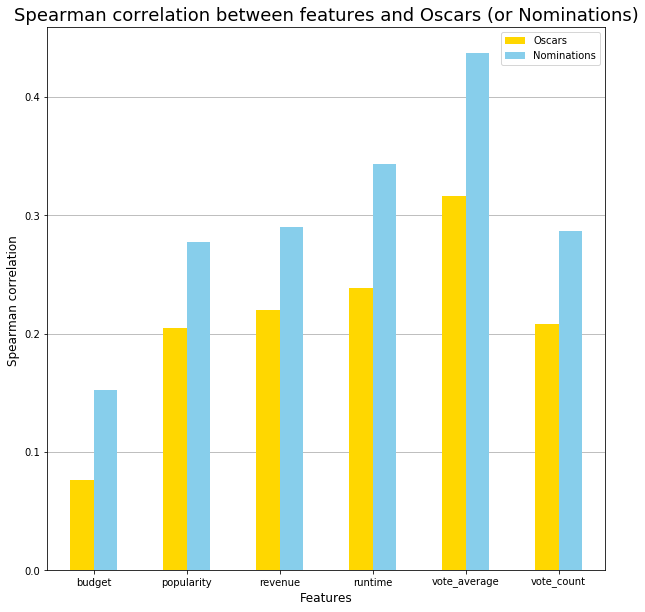

In [8]:
# Bar plots to visualize Spearman correlation
ax = corr_df.plot.bar(rot=0,figsize=(10,10),color=['gold','skyblue'])

ax.set_title("Spearman correlation between features and Oscars (or Nominations)",size=18)
ax.set_xlabel("Features",size=12)
ax.set_ylabel("Spearman correlation ",size=12)
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True)
plt.show()

# Similarity matrices exploration

In [9]:
# Loading similarity matrices previously computed
sim_mat = {}
feat_names = ['Genre','Keywords', 'Crew', 'Cast']
for name in feat_names:
    with open(Data_path+'csim_'+name, 'rb') as src:
        sim_mat[name] = pickle.load(src)
        print(f'>>> Loading {name} similarity matrix with shape {sim_mat[name].shape}')

>>> Loading Genre similarity matrix with shape (4803, 4803)
>>> Loading Keywords similarity matrix with shape (4803, 4803)
>>> Loading Crew similarity matrix with shape (4803, 4803)
>>> Loading Cast similarity matrix with shape (4803, 4803)


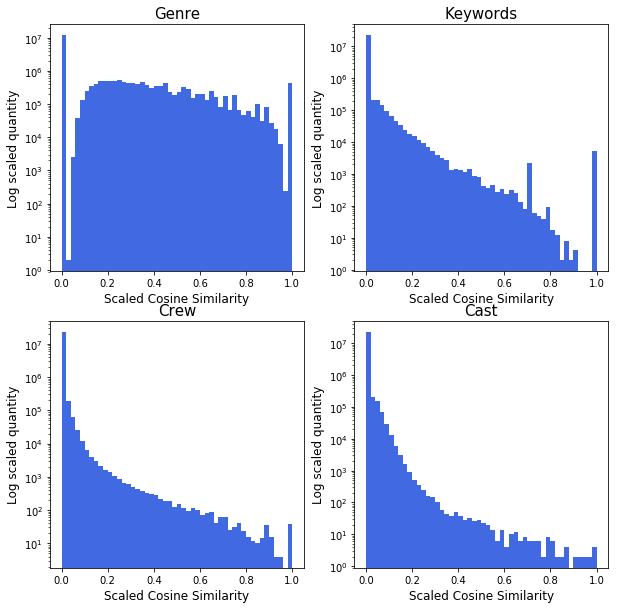

In [10]:
# Four separate graphs
fig, axs = plt.subplots(2, 2,figsize=(10, 10))
adj_mat = sim_mat.values()
for name, mat, ax in zip(feat_names, adj_mat, axs.reshape(-1)):
    ax.hist(mat.values.ravel(), log=True, bins=50,color='royalblue')
    ax.set_title(name,size=15)
    ax.set_xlabel('Scaled Cosine Similarity',size=12)
    ax.set_ylabel('Log scaled quantity',size=12)
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


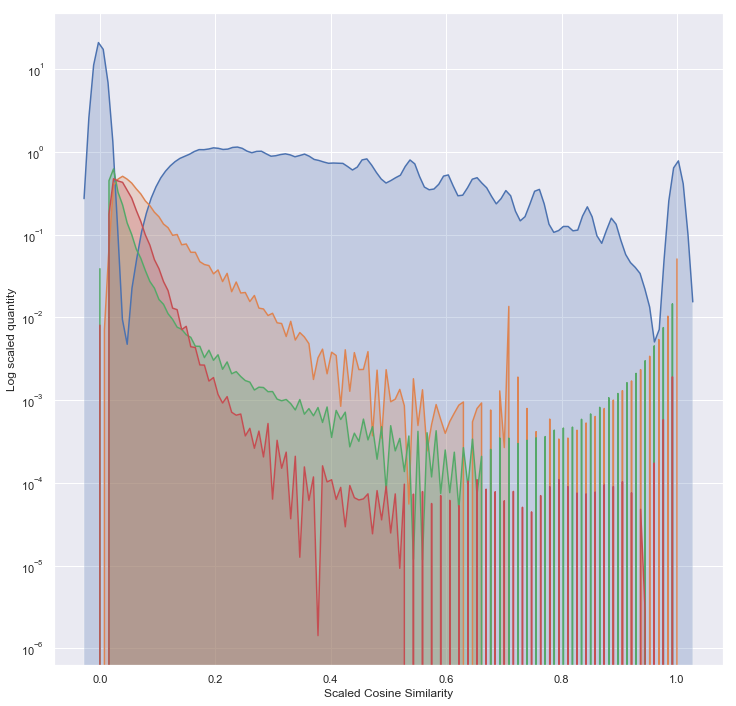

In [11]:
# Still to improve!!!!!!
for name, mat, ax in zip(feat_names, adj_mat, axs.reshape(-1)):
    sns.set(rc={'figure.figsize':(12,12)})
    ax = sns.kdeplot(mat.values.ravel(), shade=True)
    
    ax.set_xlabel('Scaled Cosine Similarity',size=12)
    ax.set_ylabel('Log scaled quantity',size=12)
    plt.yscale('log')

plt.show()